## 1. Librerias

Para empezar carguemos esas librerias que nos hacen falta

In [1]:
from tensorflow import keras as ks
from matplotlib import pyplot as plt
from keras import optimizers
import pandas as pd
import numpy as np
import time
import datetime
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from sklearn.preprocessing import LabelEncoder

## 2. Arquitectura de red del modelo


In [12]:
model = ks.Sequential()

model.add(ks.layers.Conv2D(64, (3, 3), strides=1, activation='relu', 
                          padding='same', input_shape=(32,32,3)))

model.add(ks.layers.Conv2D(128, (3, 3), strides=1, activation='relu', 
                           padding='same', input_shape=(32,32,3)))
model.add(ks.layers.MaxPooling2D((2, 2)))
model.add(ks.layers.Conv2D(128, (3, 3), strides=1, activation='relu', 
                           padding='same', input_shape=(32,32,3)))

model.add(ks.layers.BatchNormalization() )
model.add(ks.layers.Conv2D(256, (3, 3), strides=1, activation='relu', 
                           padding='same', input_shape=(32,32,3)))

model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Conv2D(256, (3, 3), strides=1, activation='relu', 
                           padding='same', input_shape=(32,32,3))) 

model.add(ks.layers.MaxPooling2D((2, 2)))
model.add(ks.layers.BatchNormalization() )
model.add(ks.layers.Conv2D(128, (3, 3), strides=1, activation='relu',
                           padding='same', input_shape=(32,32,3)))

model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Conv2D(128, (3, 3), strides=1, activation='relu', 
                           padding='same', input_shape=(32,32,3)))
model.add(ks.layers.MaxPooling2D((2, 2)))
model.add(ks.layers.Conv2D(64, (3, 3), strides=1, activation='relu', 
                           padding='same', input_shape=(32,32,3)))
model.add(ks.layers.Dropout(0.3))#
model.add(ks.layers.MaxPooling2D((2, 2)))
model.add(ks.layers.Conv2D(128, (3, 3), strides=1, activation='relu', 
                           padding='same', input_shape=(32,32,3)))
model.add(ks.layers.Conv2D(64, (3, 3), strides=1, activation='relu',
                           padding='same', input_shape=(32,32,3)))

model.add(ks.layers.BatchNormalization())
model.add(ks.layers.Flatten())
model.add(ks.layers.Dense(512, activation='relu'))
model.add(ks.layers.Dense(1024, activation='relu'))
model.add(ks.layers.Dense(512, activation='relu'))
model.add(ks.layers.Dense(256, activation='relu'))####
model.add(ks.layers.Dense(128, activation='relu'))
model.add(ks.layers.Dropout(0.3))
model.add(ks.layers.Dense(10, activation='softmax'))


Para revisar un modelo, nos basta con llamar al método **.summary()** del modelo

In [13]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 conv2d_61 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 16, 16, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_62 (Conv2D)          (None, 16, 16, 128)       147584    
                                                                 
 batch_normalization_30 (Bat  (None, 16, 16, 128)      512       
 chNormalization)                                                
                                                                 
 conv2d_63 (Conv2D)          (None, 16, 16, 256)      

## 3. Optimizador, función error


In [14]:
#from tensorflow.keras.optimizers import Adam
#new_adam = Adam(learning_rate=0.0001)

model.compile( optimizer='adam' ,
              #optimizer=new_adam,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])





## 4. Preparamos los datos

Cargamos los datos de CIFAR10 de los datasets directamente de las librerias de Keras. Estos ya estan dispuestos en train and test

**Detalle importante:** 
> La red neuronal requiere que los inputs sean números reales, y lo haremos forzando la division de los valores de dentro de las matrices 28x28 (que tienen valoress del 0 al 255) por 255.0 (un real)

In [15]:
cifar10 = ks.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train_label = y_train
y_train,y_test=y_train.flatten(),y_test.flatten()



Obtenemos un array con todas las labels de CIFAR10

In [16]:
cifar10_labels = [
'airplane', # id 0
'automobile',
'bird',
'cat',
'deer',
'dog',
'frog',
'horse',
'ship',
'truck',
]

print('Number of labels: %s' % len(cifar10_labels))

Number of labels: 10


Pintemos una muestra de las imagenes del dataset CIFAR10, a ver si se parece en algo a lo que esperamos.
Primero, vemos que tipos de datos tengo, después mapeamos esas matrices en una escala de grises utilizando el método **.get_cmap()** de PlotLy con los nueve primeros números del dataset.

Train: X=(50000, 32, 32, 3), y=(50000,)
Test: X=(10000, 32, 32, 3), y=(10000,)


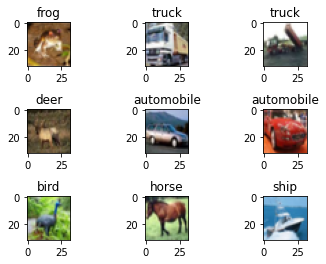

In [17]:
# Pintemos una muestra de las las imagenes del dataset MNIST

print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

for i in range(9):

    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
    plt.title(cifar10_labels[y_train_label[i,0]])

plt.subplots_adjust(hspace = 1)
plt.show()

Como vamos a querer ir haciendo validación a la vez que entrenamos (muy practico)

In [18]:
x_val = x_train[-10000:]
y_val = y_train[-10000:]

x_train = x_train[:-10000]
y_train = y_train[:-10000]


Cuando añadimos convoluciones, necesitamos "pre-tratar los datos", porque **la convolución espera una matriz de 4 campos** (más parecido a "imagenes"), en el caso de MNIST. CIFAR10 ya tiene el shape adecuado, así que no tenemos que hacer nada, pero como siempre decimos: es mejor que comprobeis su tamaño.

Por eso, al salir de la Convolution, hay que hacer un Flatten, porque las capas FullDense esperan arrays, no matrices!!

Luego lo imprimimos para ver que todo está correcto

In [19]:
# Validamos el resultado
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))
print('Validation: X=%s, y=%s' % (x_val.shape, y_val.shape))

Train: X=(40000, 32, 32, 3), y=(40000,)
Test: X=(10000, 32, 32, 3), y=(10000,)
Validation: X=(10000, 32, 32, 3), y=(10000,)


## 5. Entrenamiento

Ya podemos ponernos a entrenar el modelo!! Ojo, que hemos de entrenar contra los datos convertidos al formato que espera la Convolution.

Empezaremos con 30 epocs, es decir, 30 pasadas completas del dataset (que a su vez sera con mini-batches internamente), fijando un batch de 64

El metodo .fit() nos permite, definir además si disponemos de varias CPUs, GPUs, y si queremos ir validando datos a cada fin de epoch.

In [20]:
train_datagen= ImageDataGenerator(
    rotation_range=10,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest')

In [21]:
train_generator=train_datagen.flow(x_train, y_train, batch_size=150)

In [22]:
t = time.perf_counter()

In [23]:
from tensorflow.keras.callbacks import EarlyStopping


callback_loss = EarlyStopping(monitor='val_loss', patience=5)
callback_acc = EarlyStopping(monitor='val_accuracy', patience=5)

In [24]:
history = model.fit(
                    train_generator, epochs=300,
                    #steps_per_epoch = 150, 
                    use_multiprocessing=False, batch_size= 256, #medio alto
                    validation_data=(x_val, y_val),
                    callbacks=[callback_loss, callback_acc,
                    # Reducir la tasa de aprendizaje si la precisión no mejora en 2 epochs consecutivos
                    ks.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, 
                                                   verbose=1, mode='auto', min_lr=0.00001)]
                    )

Epoch 1/300
267/267 [==============================] - 44s 125ms/step - loss: 1.6833 - accuracy: 0.3707 - val_loss: 4.8797 - val_accuracy: 0.0989 - lr: 0.0010
Epoch 2/300
267/267 [==============================] - 30s 112ms/step - loss: 1.2876 - accuracy: 0.5410 - val_loss: 1.8705 - val_accuracy: 0.3893 - lr: 0.0010
Epoch 3/300
267/267 [==============================] - 30s 110ms/step - loss: 1.0811 - accuracy: 0.6206 - val_loss: 1.1265 - val_accuracy: 0.6257 - lr: 0.0010
Epoch 4/300
267/267 [==============================] - 30s 112ms/step - loss: 0.9597 - accuracy: 0.6660 - val_loss: 0.8899 - val_accuracy: 0.6853 - lr: 0.0010
Epoch 5/300
267/267 [==============================] - 29s 110ms/step - loss: 0.8626 - accuracy: 0.7038 - val_loss: 0.9596 - val_accuracy: 0.6861 - lr: 0.0010
Epoch 6/300
267/267 [==============================] - 29s 110ms/step - loss: 0.7826 - accuracy: 0.7322 - val_loss: 0.7346 - val_accuracy: 0.7411 - lr: 0.0010
Epoch 7/300
267/267 [=========================

In [25]:
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

print('Tiempo de entrenamiento:', elapsed_time)

Tiempo de entrenamiento: 0:16:07.957755


## 6. Evaluamos los resultados

Obtengamos una grafica de como el error y la accuracy van evolucionando en cada epoch en los datos de entrenamiento y en la validación

In [26]:
_, acc = model.evaluate(x_test, y_test, verbose=0)
print('> %.3f' % (acc * 100.0))

> 88.030


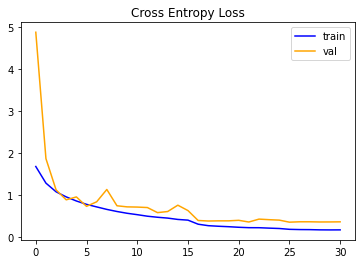

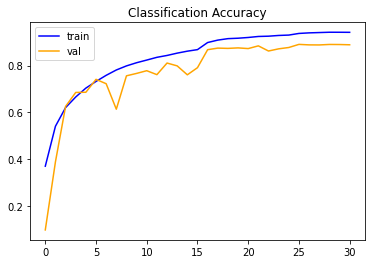

In [27]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='val')
plt.legend()
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='val')
plt.legend()
plt.show()

El coste podemos ver que es estable y es en el epoch 15 que se fija en un valor. Además la accuracy baila alrededor de 0.10. No se puede decir que sea un modelo muy bueno.

Veamos que tipo de predicciones estoy obteniendo sobre el conjunto de test (vamos a pintar las imagenes y sus clasificaciones)

In [ ]:
predictions = model.predict(x_test)

313/313 [==============================] - 2s 5ms/step


Una de las ventajas de Python es que hay montones de funciones y código realizado por terceras personas. Aquí me he fusilado unas bonitas funciones (que he adaptado un poco a mis necesidades) para poder pintar las imagenes, su label (ground truth) y las clasificaciones que hemos realizado.

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label[0]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label[0]].set_color('blue')

Dibujamos las primeras imagenes, con las predicciones y sus valores reales (un total de 20 imagenes, para no abusar de vuestros laptops)

Coloreamos las prediciones correctas en azul y los fallos en rojo. Aunque primero he impreso las etiquetas para que tengamos una referencia al grafico.

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


IndexError: ignored

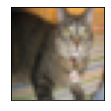

In [ ]:
i = 0
for l in cifar10_labels:
    print(i, l)
    i += 1

num_rows = 5
num_cols = 4
start = 650
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i+start, predictions[i+start], y_test, x_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i+start, predictions[i+start], y_test)
plt.tight_layout()
plt.show()

## 7. Guardamos el modelo para futuras evaluaciones

Id cambiando los nombres del archivo para ir guardando los diversos proyectos.
Aquí lo guardamos en "local", pero recordad que lo ideal es que lo guardeis en Google Drive (teneis que montar la unidad, fijar la ruta y allí guardar el modelo .h5)

In [ ]:
model.save('cifar10_base_model.h5')